In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
import scipy.stats as st
from astropy.stats import LombScargle
from astropy.io import fits
sns.set_context('notebook')
plt.style.use('seaborn')
style = {
    'figure.figsize': (12, 8),
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 14,
}
rcParams.update(style)
import pymc3 as pm

In [3]:
lc = pd.read_table('data/kplr007107778_kasoc-ts_slc_v1.dat', sep='\s+', comment='#', names=['time', 'flux', 'flux_error'], dtype='f8')
psd = pd.read_table('data/kplr007107778_kasoc-psd_slc_v1.pow', sep='\s+', comment='#', names=['freq', 'power'], dtype='f8')

In [4]:
t = lc['time']
f = lc['flux']
ferr = lc['flux_error']

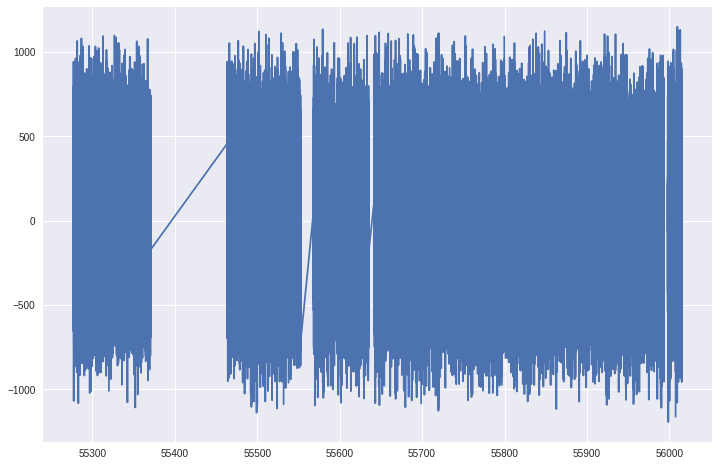

In [5]:
plt.plot(t, f);

In [59]:
freq, power = LombScargle(t, f, dy=ferr, fit_mean=False, center_data=False, normalization='psd').autopower()

In [6]:
mask = psd['freq'] > 12
full_freq = psd['freq'][mask]
full_power = psd['power'][mask]

In [7]:
freq = np.arange(min(full_freq), max(full_freq), 6)
power = np.interp(freq, full_freq, full_power)
# freq = full_freq
# power = full_power

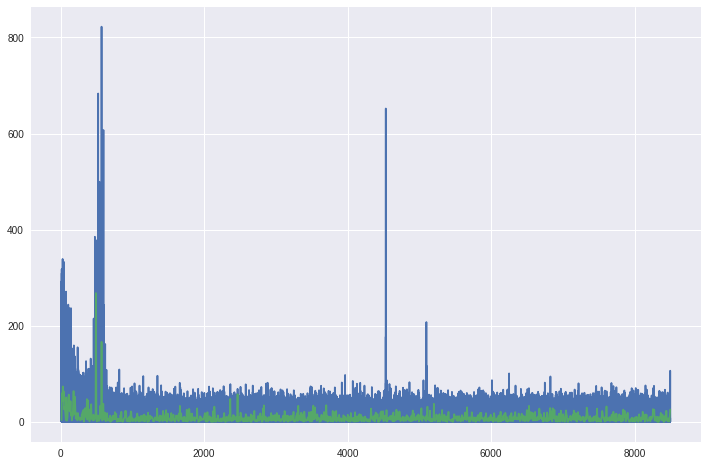

In [8]:
plt.plot(full_freq, full_power)
plt.plot(freq, power);

In [11]:
v_nyq = 8496.36
with pm.Model() as model:
    W = pm.Bound(pm.Normal, lower=0)('W', mu=0, sd=100)
    print('made it to W')
    R_v = (pm.math.sin( np.pi * freq / (2 * v_nyq)) / ((np.pi * freq) / (2 * v_nyq)))**2
    
    print('made it to RV')
    k=3
    a = pm.Normal('a', mu=0, sd=10, shape=(k,1))
    
    print('made it to a')
    b = pm.Normal('b', mu=0, sd=10, shape=(k,1))
    
    print('made it to b')
    harv = pm.math.sum(2 * pm.math.sqrt(2) / np.pi * (a**2 / b) / (1 + (freq / b)**4), axis=0)
    
    print('made it to harv')
    H0 = pm.Bound(pm.Normal, lower=0)('H0', mu=0, sd=10)
    print('made it to H0')
    v_max = pm.Bound(pm.Normal, lower=0)('v_max', mu=0, sd=10)
    
    print('made it to vmax')
    s = pm.HalfCauchy('s', 10)
    
    print('made it to s')
    like = W + R_v * (harv + H0 * pm.math.exp(-(freq - v_max)**2) / (2 * s**2))
    
    print('made it to like')
    y = pm.Normal('obs', like, observed=power)
    

made it to W
made it to RV
made it to a
made it to b
made it to harv
made it to H0
made it to vmax
made it to s
made it to like


In [16]:
with model:
    trace = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s_log__, v_max_lowerbound__, H0_lowerbound__, b, a, W_lowerbound__]
100%|██████████| 10000/10000 [06:59<00:00, 23.84it/s]
There were 718 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6152419339357783, but should be close to 0.8. Try to increase the number of tuning steps.
There were 303 divergences after tuning. Increase `target_accept` or reparameterize.
There were 384 divergences after tuning. Increase `target_accept` or reparameterize.
There were 316 divergences after tuning. Increase `target_accept`

In [17]:
pm.gelman_rubin(trace)

{'H0': 0.9999916407558193, 'W': 1.0036461668946028, 'a': array([[29.61623034],
        [23.2067348 ],
        [55.53850256]]), 'b': array([[52.26356694],
        [95.19899619],
        [53.44987178]]), 's': 1.0221379255162357, 'v_max': 7.302331812206111}

In [56]:
ppc = pm.sample_ppc(trace, 1000, model)
post = ppc['obs'].mean(axis=0)

100%|██████████| 1000/1000 [00:01<00:00, 820.03it/s]
